## Test individual sea level contributors

In [1]:
import glob
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import xarray as xr
from IPython.display import display

import func_odyn as odyn
import func_misc as misc
import func_gic as gic
import func_gre as gre
import func_ant as ant
import func_B19 as b19

# Interactive plots
#%matplotlib widget
# Static plots
%matplotlib inline

In [21]:
importlib.reload(odyn)
importlib.reload(misc)
importlib.reload(ant)


<module 'func_ant' from '../code/func_ant.py'>

In [2]:
SCE = 'rcp85'
ROOT = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
DIR_T = ROOT+'Data_AR5/Tglobal/'
DIR_T_cmip6 = f'{ROOT}Data_CMIP6/tas-global-averaged_20200429/'
#DIR_T_cmip6 = f'{ROOT}Data_CMIP6/tas-global-area-averaged/'
DIR_IPCC = ROOT+'Data_AR5/Final_Projections/'
DIR_O       = ROOT + 'Data_AR5/Ocean/1x1_reg/'
DIR_OG      = ROOT + 'Data_AR5/Ocean/globalmeans_from_1x1_glob/'

N = int(1e5)
start_date = 1980    # Start reading data
ys = 2006   # Starting point for the integration, if this is changed problems in functions
ye = 2100   # End year for computation
nb_y = ye-start_date+1       # Period where data needs to be read
nb_y2 = ye - ys +1           # Period of integration of the model
TIME       = np.arange( start_date, ye + 1 )
TIME2      = np.arange( ys, ye + 1, 1 )
GAM = 1
GRE = 'KNMI14'
NormD  = np.random.normal(0, 1, N)
Aoc = 3.6704e14              # Ocean Area (m2)
rho_w = 1e3                  # Water density (kg.m-3)
fac = -1e12 / (Aoc * rho_w)  # Convert Giga tones to m sea level
MOD = ["ACCESS1-0","BCC-CSM1-1","CanESM2","CNRM-CM5","CSIRO-Mk3-6-0","GFDL-ESM2G", \
    "GFDL-ESM2M","GISS-E2-R","HadGEM2-CC","HadGEM2-ES","inmcm4","IPSL-CM5A-LR", \
    "IPSL-CM5A-MR","MIROC5","MIROC-ESM-CHEM","MIROC-ESM","MPI-ESM-LR","MPI-ESM-MR", \
    "MRI-CGCM3","NorESM1-ME","NorESM1-M"]
i_ys   = np.where(TIME == ys)[0][0]

#### Specific parameters
## Initial Antarctic dynamics contribution
a1_up_a           = 0.061    # Unit is cm/y, equal to observations in 2006
a1_lo_a           = 0.021
## Initial Greenland dynamics contribution
a1_up_g           = 0.076    # Unit is cm/y, equal to observations in 2006
a1_lo_g           = 0.043

ref_steric = [1986, 2005] # Reference period for steric sea level

In [3]:
def comp_plot_dist(X_ens, lo, hi, title_in, SCE):
    '''Easily compute the distribution, plot a histogram and table of percentile 
    values'''
    nbin = int(hi - lo)*20 
    X_pdf, bins = np.histogram(X_ens, bins=nbin, range=(lo, hi), density=True)
    bin_centers = (bins[1:] + bins[:-1])/2

    plt.bar(bin_centers, X_pdf, width=1)
    plt.ylabel('PDF')
    plt.title(title_in + ' for '+SCE)
    plt.show()
    
    Perc  = (1,5,10,17,20,50,80,83,90,95,99,99.5,99.9)
    perc = misc.perc_df(X_pdf, Perc, bin_centers)
    print("### Distribution ###")
    display(perc)

### Test ocean dynamics function: odyn.odyn_glob_ipcc

(3, 100000, 95)


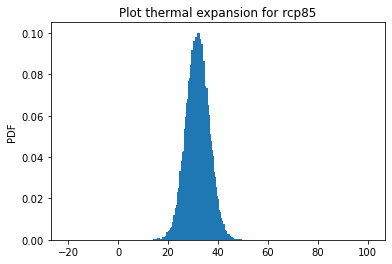

### Distribution ###


,values
percentiles,
1.0,21.825
5.0,24.725
10.0,26.275
17.0,27.675
20.0,28.125
50.0,31.775
80.0,35.375
83.0,35.875
90.0,37.275


In [5]:
X_O = odyn.odyn_glob_ipcc(SCE, DIR_IPCC, N, nb_y2, GAM, NormD)
print(X_O.shape)
comp_plot_dist(X_O[0,:,-1], -20.5, 100.5, 'Plot thermal expansion', SCE)


### Test ocean dynamics function: odyn.odyn_loc

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(3, 100000, 95)


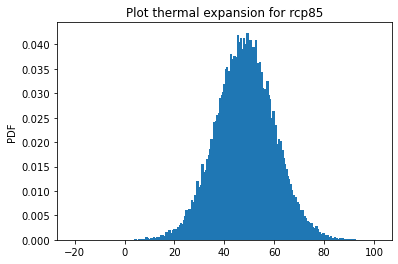

### Distribution ###


,values
percentiles,
1.0,23.025
5.0,30.375
10.0,34.275
17.0,37.925
20.0,39.075
50.0,48.275
80.0,57.525
83.0,58.725
90.0,62.325


In [6]:
LOC = 60, 51, -3.5, 7.5 # lat_N, lat_S, lon_W, lon_E
LowPass = False

X_O = odyn.odyn_loc(SCE, MOD, DIR_O, DIR_OG, LOC, 
                    ref_steric, ye, N, ys, GAM, NormD, LowPass)
print(X_O.shape)
comp_plot_dist(X_O[0,:,-1], -20.5, 100.5, 'Plot thermal expansion', SCE)


### Test ocean dynamics function: odyn.odyn_cmip

In [69]:
# Works for ye greater than 2100 if LowPass is on by extrapolating a 2nd order fit of each model in the future 
importlib.reload(odyn)

<module 'func_odyn' from '../code/func_odyn.py'>

(3, 100000, 95)


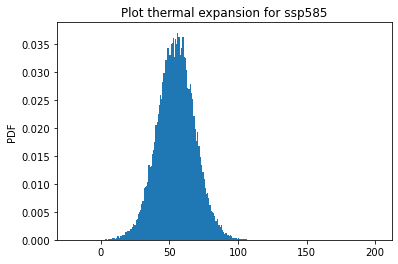

### Distribution ###


,values
percentiles,
1.0,25.375
5.0,33.975
10.0,38.475
17.0,42.675
20.0,44.025
50.0,54.725
80.0,65.425
83.0,66.825
90.0,71.025


In [70]:
LowPass = False
LOC = [60, 51, -3.5, 7.5]
DIR_CMIP = '../../CMIP_SeaLevel/outputs/'

X_O2 = odyn.odyn_cmip('ssp585', DIR_CMIP, LOC, 
                     ref_steric, 2100, N, ys, GAM, NormD, LowPass)
print(X_O2.shape)
comp_plot_dist(X_O2[0,:,-1], -20.5, 200.5, 'Plot thermal expansion', SCE)

/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dewilebars/anaconda3/envs/p38ds/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(3, 100000, 95)


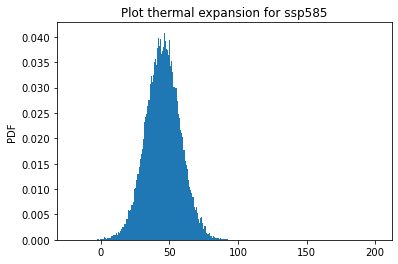

### Distribution ###


,values
percentiles,
1.0,18.025
5.0,25.925
10.0,30.125
17.0,34.025
20.0,35.275
50.0,45.125
80.0,55.025
83.0,56.325
90.0,60.175


In [76]:
X_O2 = odyn.odyn_cmip('rcp85', DIR_CMIP, LOC, 
                     ref_steric, 2100, N, ys, GAM, NormD, LowPass)
print(X_O2.shape)
comp_plot_dist(X_O2[0,:,-1], -20.5, 200.5, 'Plot thermal expansion', SCE)

### Test the temperature projection function

In [104]:
importlib.reload(misc)

<module 'func_misc' from '../code/func_misc.py'>

In [5]:
def comp_plot_dist_temp(X_ens, lo, hi, title_in, SCE):
    '''Easily compute the distribution, plot a histogram and table of percentile 
    values'''
    nbin = 100
    X_pdf, bins = np.histogram(X_ens, bins=nbin, range=(lo, hi), density=True)
    bin_centers = (bins[1:] + bins[:-1])/2

    plt.bar(bin_centers, X_pdf, width=1)
    plt.ylabel('PDF')
    plt.title(title_in + ' for '+SCE)
    plt.show()
    
    Perc  = (1,5,10,17,20,50,80,83,90,95,99,99.5,99.9)
    perc = misc.perc_df(X_pdf, Perc, bin_centers)
    print("### Distribution ###")
    display(perc)

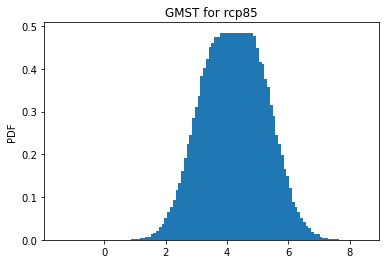

### Distribution ###


,values
percentiles,
1.0,2.285
5.0,2.825
10.0,3.095
17.0,3.365
20.0,3.455
50.0,4.175
80.0,4.895
83.0,4.985
90.0,5.255


In [6]:
LowPass = False
SCE = 'rcp85'
ye = 2100

path = DIR_T+'global_tas_Amon_*_'+SCE+'_r1i1p1.dat'
files  = glob.glob(path)

TGLOB = misc.tglob_cmip5( files, SCE, start_date, ye , LowPass, False)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
comp_plot_dist_temp(Td_gic[:,-1], -1, 8, 'GMST', SCE)

In [99]:
TGLOB = misc.tglob_cmip6(DIR_T_cmip6, 'ssp585', start_date, ye, LowPass, False)
TGLOBs = TGLOB.sel(time=slice(ys,None))

T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
comp_plot_dist_temp(Td_gic[:,-1], -1, 8, 'GMST', SCE)

No README file in folder
Some years are missing for tas CAMS-CSM1-0
[1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099]
Filing up the gap by extrapolation


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

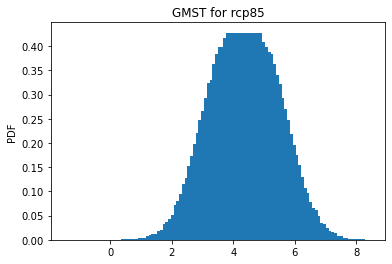

### Distribution ###


,values
percentiles,
1.0,2.105
5.0,2.735
10.0,3.095
17.0,3.455
20.0,3.545
50.0,4.355
80.0,5.075
83.0,5.165
90.0,5.525


In [105]:
TGLOB = misc.tglob_ar6('ssp585', start_date, ye)
TGLOBs = TGLOB.sel(time=slice(ys,None))

T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
comp_plot_dist_temp(Td_gic[:,-1], -1, 8, 'GMST', SCE)

AR6 provides temperature projections for ssp585 just a tiny bit higher than rcp85 in AR5

### Test the glacier projection function

In [8]:
importlib.reload(gic)

<module 'func_gic' from '../code/func_gic.py'>

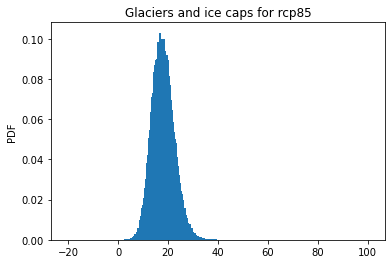

### Distribution ###


,values
percentiles,
1.0,8.975
5.0,11.375
10.0,12.675
17.0,13.875
20.0,14.325
50.0,17.725
80.0,21.425
83.0,21.925
90.0,23.475


In [13]:
NormDs  = np.random.normal(0, 1, N)   # This distribution is then kept for correlation
X_gic = gic.gic(Td_gic, NormDs, 'AR5')
comp_plot_dist(X_gic[:,-1], -20.5, 100.5, 'Glaciers and ice caps', SCE)


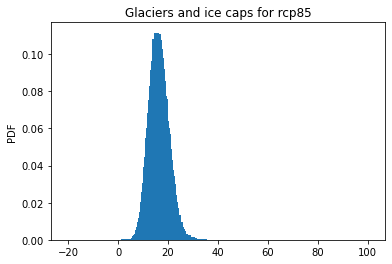

### Distribution ###


,values
percentiles,
1.0,8.275
5.0,10.325
10.0,11.525
17.0,12.625
20.0,13.025
50.0,16.075
80.0,19.375
83.0,19.875
90.0,21.225


In [15]:
NormDs  = np.random.normal(0, 1, N)   # This distribution is then kept for correlation
X_gic = gic.gic_ipcc(Td_gic, NormDs, 'AR6')
comp_plot_dist(X_gic[:,-1], -20.5, 100.5, 'Glaciers and ice caps', SCE)


### Test the Greenland SMB function

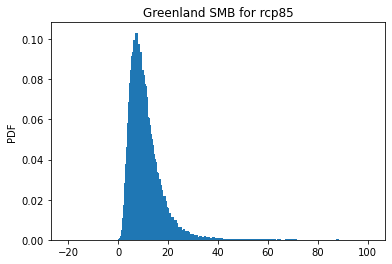

### Distribution ###


,values
percentiles,
1.0,2.625
5.0,3.875
10.0,4.725
17.0,5.625
20.0,5.925
50.0,9.275
80.0,14.275
83.0,15.125
90.0,17.825


In [12]:
T_g = TGLOBs - TGLOB.sel(time=slice(1980,1999)).mean(dim='time')
Td_g = misc.normal_distrib(T_g, GAM, NormD)

NormDl = np.random.normal(0, 1, N)
X_gsmb = gre.fett13(fac, Td_g, NormDl, GRE)
comp_plot_dist(X_gsmb[:,-1], -20.5, 100.5, 'Greenland SMB', SCE)

### Test Antarctic SMB

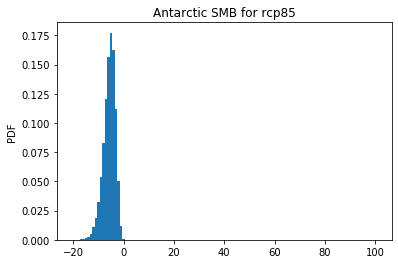

### Distribution ###


,values
percentiles,
1.0,-13.0
5.0,-11.0
10.0,-9.0
17.0,-8.0
20.0,-8.0
50.0,-6.0
80.0,-4.0
83.0,-4.0
90.0,-3.0


In [70]:
Tref_a = misc.Tref(1985, 2005, TGLOB, TIME)   # Antarctic SMB
Td_a = misc.TempDist(TGLOBs, Tref_a, GAM, NormD)
NormDl = np.random.normal(0, 1, N)
X_asmb = ant.ant_smb_ar5(NormDl, fac, Td_a)
comp_plot_dist(X_asmb[:,-1], -20.5, 100.5, 'Antarctic SMB', SCE)

### Test land water storage

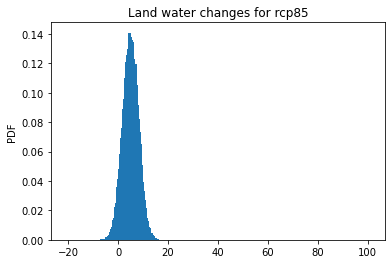

### Distribution ###


,values
percentiles,
1.0,-2.075
5.0,-0.025
10.0,1.075
17.0,2.075
20.0,2.425
50.0,4.975
80.0,7.525
83.0,7.875
90.0,8.825


In [21]:
X_landw = misc.landw_ar5(ys, TIME2, N)
comp_plot_dist(X_landw[:,-1], -20.5, 100.5, 'Land water changes', SCE)

### Test Antarctic dynamics

### AR5

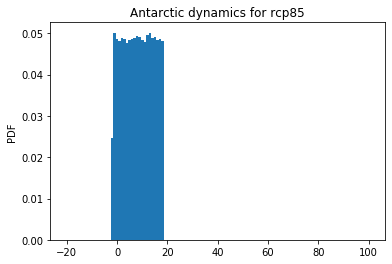

### Distribution ###


,values
percentiles,
1.0,-20.0
5.0,-1.0
10.0,0.0
17.0,1.0
20.0,2.0
50.0,8.0
80.0,14.0
83.0,14.0
90.0,16.0


In [72]:
Unif_AA   = np.random.uniform(0, 1, N)
#### 2nd order projection starting from observations and ending between -2 and 18.5 cm
X_ant = misc.proj2order(TIME2, a1_up_a, a1_lo_a, 18.5, -2, Unif_AA)
comp_plot_dist(X_ant[:,-1], -20.5, 100.5, 'Antarctic dynamics', SCE)

### SROCC

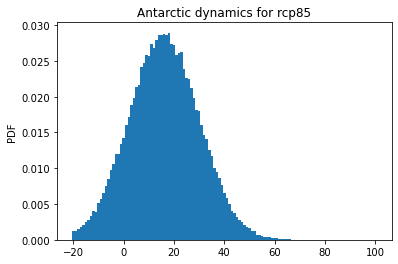

### Distribution ###


,values
percentiles,
1.0,-15.0
5.0,-7.0
10.0,-2.0
17.0,2.0
20.0,4.0
50.0,16.0
80.0,27.0
83.0,29.0
90.0,33.0


In [9]:
X_ant = ant.ant_dyn_srocc(SCE, a1_up_a, a1_lo_a, TIME2, N)
comp_plot_dist(X_ant[:,-1], -20.5, 100.5, 'Antarctic dynamics', SCE)

### AR6

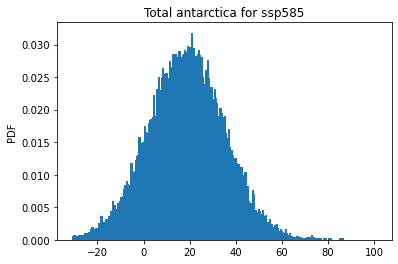

### Distribution ###


,values
percentiles,
1.0,-16.675
5.0,-6.825
10.0,-1.325
17.0,3.725
20.0,5.475
50.0,18.475
80.0,31.475
83.0,33.225
90.0,38.325


In [25]:
SCE = 'ssp585'
X_ant = ant.ant_ar6(TIME2, a1_up_a, a1_lo_a, SCE, NormD)
comp_plot_dist(X_ant[:,-1], -30.5, 100.5, 'Total antarctica', SCE)

In [24]:
TIME2

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
       2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,
       2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099, 2100])

### Test Greenland dynamics

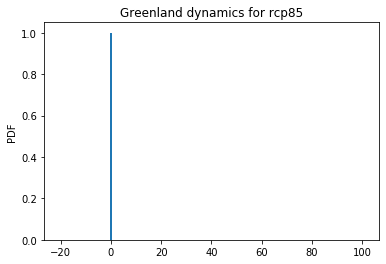

### Distribution ###


,values
percentiles,
1.0,-20.0
5.0,-20.0
10.0,-20.0
17.0,-20.0
20.0,-20.0
50.0,-20.0
80.0,0.0
83.0,0.0
90.0,0.0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [73]:
# First order term (cm/y), equal to half of observations in 2006
a1_up_gdyn        = 0.5 * a1_up_g
a1_lo_gdyn        = 0.5 * a1_lo_g
UnifDd = np.random.uniform(0, 1, N)  # Sample a new independent distribution

if GRE == 'KNMI14':
    X_gre  = misc.proj2order(TIME2, a1_up_gdyn, a1_lo_gdyn, 7.4, 1.7, UnifDd)
elif GRE == 'IPCC':
    if SCE in ['rcp26', 'rcp45']:
        Delta_gre_up_2100 = 6.3
        Delta_gre_lo_2100 = 1.4
    elif SCE == 'rcp85':
        Delta_gre_up_2100 = 8.5
        Delta_gre_lo_2100 = 2
    X_gre  = misc.proj2order(TIME2, a1_up_gdyn, a1_lo_gdyn, Delta_gre_up_2100, 
                        Delta_gre_lo_2100, UnifDd)
comp_plot_dist(X_gre[:,10], -20.5, 100.5, 'Greenland dynamics', SCE)

lo = -20.5
hi = 100.5
nbin = int(hi - lo) 
X_gre_pdf, bins = np.histogram(X_gre[:,10], bins=nbin, range=(lo, hi), density=True)
X_gre_pdf

### Test antarctic dynamics from KNMI14 projections 

../code/func_ant.py:65: RuntimeWarning: divide by zero encountered in log
  sig_ant  = 1/alpha_98*np.log((Delta_ant_up_KNMI-Delta_ant_lo)/Diff)


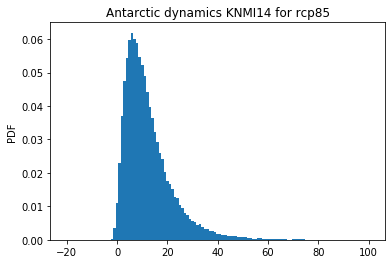

### Distribution ###


,values
percentiles,
1.0,0.0
5.0,1.0
10.0,3.0
17.0,4.0
20.0,4.0
50.0,10.0
80.0,18.0
83.0,19.0
90.0,24.0


In [74]:
X_ant_KNMI14 = ant.ant_dyn_knmi14(SCE, a1_up_a, a1_lo_a, ys, ye, TIME2, N)
comp_plot_dist(X_ant_KNMI14[:,-1], -20.5, 100.5, 'Antarctic dynamics KNMI14', 
               SCE)


### Tables of global results

In [75]:
AR5_df = pd.read_csv('../ref_results/SLR_AR5_2100', sep=';', comment='#') # , header=1
AR5_df = AR5_df.set_index('Processes')
AR5_df


,A1B med,A1B 5th,A1B 95th,RCP2.6 med,RCP2.6 5th,RCP2.6 95th,RCP4.5 med,RCP4.5 5th,RCP4.5 95th,RCP6.0 med,RCP6.0 5th,RCP6.0 95th,RCP8.5 med,RCP8.5 5th,RCP8.5 95th
Processes,,,,,,,,,,,,,,,
Thermal expansion,0.24,0.18,0.30,0.15,0.11,0.20,0.20,0.15,0.25,0.22,0.17,0.27,0.32,0.25,0.39
Glaciers,0.16,0.09,0.23,0.11,0.05,0.17,0.13,0.07,0.20,0.14,0.07,0.20,0.18,0.10,0.26
Greenland Ice Sheet SMB,0.07,0.03,0.15,0.03,0.01,0.08,0.05,0.02,0.11,0.05,0.02,0.12,0.10,0.04,0.22
Antarctic Ice Sheet SMB,–0.04,–0.07,–0.01,–0.02,–0.05,–0.00,–0.03,–0.06,–0.01,–0.03,–0.06,–0.01,–0.05,–0.09,–0.02
Greenland Ice Sheet Rapid Dynamics,0.04,0.01,0.06,0.04,0.01,0.06,0.04,0.01,0.06,0.04,0.01,0.06,0.05,0.02,0.09
Antarctic Ice Sheet Rapid Dynamics,0.08,–0.02,0.19,0.08,–0.02,0.19,0.08,–0.02,0.19,0.08,–0.02,0.19,0.08,–0.02,0.19
Land Water Storage,0.05,–0.01,0.11,0.05,–0.01,0.11,0.05,–0.01,0.11,0.05,–0.01,0.11,0.05,–0.01,0.11
Sea Level Rise,0.60,0.42,0.80,0.44,0.28,0.61,0.53,0.36,0.71,0.55,0.38,0.73,0.74,0.52,0.98
Greenland Ice Sheet,0.11,0.07,0.19,0.08,0.04,0.12,0.09,0.05,0.16,0.09,0.06,0.16,0.15,0.09,0.28


### Test Bamber et al. 2019 functions

In [76]:
importlib.reload(b19)

<module 'func_B19' from '../code/func_B19.py'>

In [77]:
path = '../../BamberDataDistribution/parameters_mean_std_opt.csv'
PAR_ar = b19.ReadB19(path)
PAR_ar

array([[[[ 0.9585524 ,  0.77373971],
         [ 0.79219789,  1.265177  ]],

        [[ 2.        ,  5.        ],
         [ 3.        ,  0.        ]],

        [[ 5.02844808, 17.99010175],
         [ 7.14703945, 26.44528395]]],


       [[[ 1.19811757,  0.64641699],
         [ 0.9684769 ,  0.66677909]],

        [[ 0.        ,  1.        ],
         [ 0.        ,  1.        ]],

        [[ 4.40567565, 18.87865761],
         [ 5.9365423 , 40.12039764]]],


       [[[ 2.16853964,  0.15616428],
         [ 1.48937135,  0.23388903]],

        [[-3.        ,  1.        ],
         [-4.        ,  1.        ]],

        [[ 1.38448557, 12.90129197],
         [ 2.86618874, 26.96745124]]]])

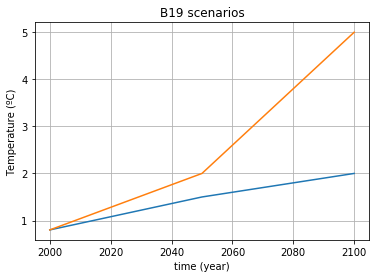

In [78]:
# Bamber et al. 2019 temperature pathways
t0 = 2000
t1 = 2050
t2 = 2100

# First order interpolation along temperature integral
# Define the temperature functions for the low and high scenarios
T0 = 0.8     # Should be floats, integers lead to problem in the computations
Tl50 = 1.5
Tl100 = 2.
Th50 = 2.
Th100 = 5.

Tl = b19.TempF(T0, Tl50, Tl100, t0, t1, t2)
Th = b19.TempF(T0, Th50, Th100, t0, t1, t2)

### Plot
t = np.arange(t0, t2+1)

fig, ax = plt.subplots()
ax.plot(t, Tl)
ax.plot(t, Th)

ax.set(xlabel='time (year)', ylabel='Temperature (ºC)',
       title='B19 scenarios')
ax.grid()

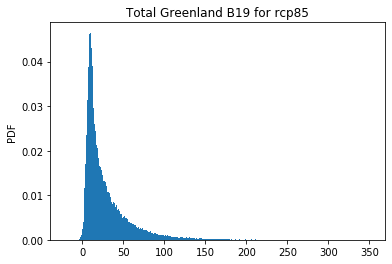

### Distribution ###


,values
percentiles,
1.0,1.0
5.0,4.0
10.0,6.0
17.0,8.0
20.0,8.0
50.0,17.0
80.0,43.0
83.0,47.0
90.0,64.0


In [79]:
# Greenland
GAM = 1.64
Tref_b   = misc.Tref(2000, 2000, TGLOB, TIME)
Td_b = misc.TempDist(TGLOBs, Tref_b, GAM, NormD)

UnifP_GIS = np.random.uniform(0, 1, N)

X_gsmb = b19.Bamber19('GIS', UnifP_GIS, [a1_lo_g, a1_up_g], ys, Td_b)
X_gsmb = X_gsmb + 0.3    # Contribution between 1995 and 2005 in mm

comp_plot_dist(X_gsmb[:,-1], -20.5, 350.5, 'Total Greenland B19', 
               SCE)
# !!! The above computation is sensitive to the right end of the 
#histogram computation

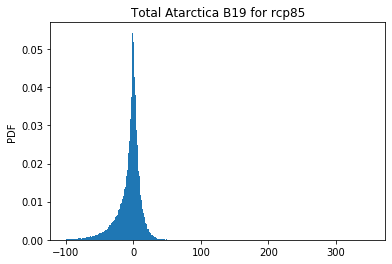

### Distribution ###


,values
percentiles,
1.0,-69.0
5.0,-41.0
10.0,-28.0
17.0,-18.0
20.0,-16.0
50.0,-2.0
80.0,5.0
83.0,6.0
90.0,10.0


In [80]:
# Antarctica
UnifP_WAIS = np.random.uniform(0, 1, N)
UnifP_EAIS = np.random.uniform(0, 1, N)

X_ant_wais = b19.Bamber19("WAIS", UnifP_WAIS, [a1_lo_a, a1_up_a], ys, Td_b)
X_ant_eais = b19.Bamber19("EAIS", UnifP_EAIS, [0, 0], ys, Td_b)
X_ant = X_ant_wais + X_ant_eais    # Contribution between 1995 and 2005 in mm

comp_plot_dist(X_ant[:,50], -100.5, 350.5, 'Total Atarctica B19', 
               SCE)

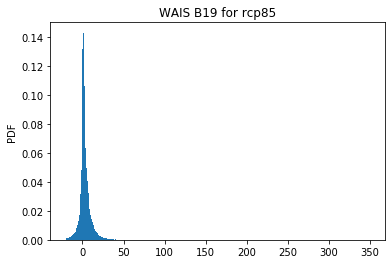

### Distribution ###


,values
percentiles,
1.0,-14.0
5.0,-7.0
10.0,-3.0
17.0,-1.0
20.0,-1.0
50.0,1.0
80.0,6.0
83.0,7.0
90.0,10.0


In [81]:
comp_plot_dist(X_ant_wais[:,50], -20.5, 350.5, 'WAIS B19', 
               SCE)

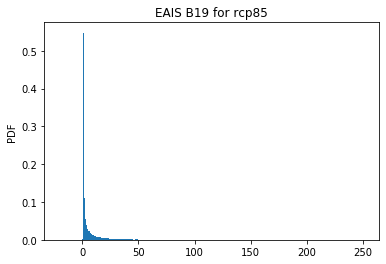

### Distribution ###


,values
percentiles,
1.0,0.0
5.0,0.0
10.0,0.0
17.0,0.0
20.0,0.0
50.0,1.0
80.0,6.0
83.0,7.0
90.0,14.0


In [82]:
comp_plot_dist(X_ant_eais[:,-1], -20.5, 250.5, 'EAIS B19', 
               SCE)